<a href="https://colab.research.google.com/github/noahjett/Movie-Goodreads-Analysis/blob/master/Book_Movie_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie & Book Reviews Project

Author: Noah Jett

Date: 11/13/2019

Made as part of Data Science 377 at Illinois Wesleyan University

### This project seeks to explore two well documented datasets from popular data science site Kaggle, 'Goodreads-books' and 'TMDB 5000 Movie Dataset'. 





### Dataset 1: Goodreads-books from Kaggle
Goodreads-books is data pulled from popular book review and reccomendation site Goodreads. Each entry in this dataset is a unique book, and contains information like author, pages, average rating, and number of reviews. The data was scraped from the site directly using the publically available Goodreads API.

Can be found here:
https://www.kaggle.com/jealousleopard/goodreadsbooks



### Dataset 2: TMDB 5000 Movie Dataset from Kaggle
Data on 5000 movies scraped from The Movie Database (TMDB).

Can be found here:
https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_credits.csv



### The goal of this project is to combine these datasets, and look at entries occurring in both datasets, i.e. books which have a movie adaptation. 

### Research Questions: 
1.   What is the relationship between movies based on a book, and movies not based on a book?
2. Alternatively, are books with movie adaptations rated differently than those without? How?

An important note is that merging the two datasets is itself an important goal of the project. Combining datasets can create value by allowing future data scientists to look at data in different ways, and ask different questions.




### Ethics Statement

This project uses two publically available datasets, which can be found here https://www.kaggle.com/jealousleopard/goodreadsbooks, and here https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_credits.csv.

These datasets were created through publically available APIs, and are some of the highest rated sets on the popular data science site Kaggle. They do not contain any private information on persons or compaines. The movie dataset contains information about movie budgets and revenues, both of which are publically available information. 

The result of this project, to combine the datasets and identify relationships between them, should not have any negative impact on specific works or their creators. The subjects of the datasets can realistically only gain from the information created from this project.

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth',1000)

In [2]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144668 sha256=050390c0c256a36e509c3d26aae1080b9fad4a506d96dabfd2036e6d71acf205
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [0]:
import fuzzywuzzy
from fuzzywuzzy import process 

### Import Method: From Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
path1 = "/content/drive/My Drive/data/books.csv"
books = pd.read_csv(path1, error_bad_lines=False)

path2 = "/content/drive/My Drive/data/tmdb_5000_movies.csv"
movies = pd.read_csv(path2, error_bad_lines=False)

path3 = "/content/drive/My Drive/data/tmdb_5000_credits.csv"
credits = pd.read_csv(path3, error_bad_lines=False)

b'Skipping line 4012: expected 10 fields, saw 11\nSkipping line 5688: expected 10 fields, saw 11\nSkipping line 7056: expected 10 fields, saw 11\nSkipping line 10601: expected 10 fields, saw 11\nSkipping line 10668: expected 10 fields, saw 11\n'


### Goodreads: Check for Missing Values

In [6]:
books.isna().sum()
#books.dropna()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
# num_pages           0
ratings_count         0
text_reviews_count    0
dtype: int64

### Goodreads dataset has no missing values

### Goodreads descriptives

In [7]:
books.head(10)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
0,1,Harry Potter and the Half-Blood Prince (Harry Potter #6),J.K. Rowling-Mary GrandPré,4.56,0439785960,9780439785969,eng,652,1944099,26249
1,2,Harry Potter and the Order of the Phoenix (Harry Potter #5),J.K. Rowling-Mary GrandPré,4.49,0439358078,9780439358071,eng,870,1996446,27613
2,3,Harry Potter and the Sorcerer's Stone (Harry Potter #1),J.K. Rowling-Mary GrandPré,4.47,0439554934,9780439554930,eng,320,5629932,70390
3,4,Harry Potter and the Chamber of Secrets (Harry Potter #2),J.K. Rowling,4.41,0439554896,9780439554893,eng,352,6267,272
4,5,Harry Potter and the Prisoner of Azkaban (Harry Potter #3),J.K. Rowling-Mary GrandPré,4.55,043965548X,9780439655484,eng,435,2149872,33964
5,8,Harry Potter Boxed Set Books 1-5 (Harry Potter #1-5),J.K. Rowling-Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,38872,154
6,9,"Unauthorized Harry Potter Book Seven News: ""Half-Blood Prince"" Analysis and Speculation",W. Frederick Zimmerman,3.69,0976540606,9780976540601,en-US,152,18,1
7,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,27410,820
8,12,The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Hitchhiker's Guide to the Galaxy #1-5),Douglas Adams,4.38,0517226952,9780517226957,eng,815,3602,258
9,13,The Ultimate Hitchhiker's Guide to the Galaxy,Douglas Adams,4.38,0345453743,9780345453747,eng,815,240189,3954


### Notice how there are several formats for J.K. Rowling's name, and at least two language codes for English (eng & en-US)

### Implies some cleaning will need to be done

Changes language code 'en-US' to 'eng'

In [0]:
books.loc[(books['language_code'] == 'en-US'), 'language_code'] = 'eng'


In [9]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13714 entries, 0 to 13713
Data columns (total 10 columns):
bookID                13714 non-null int64
title                 13714 non-null object
authors               13714 non-null object
average_rating        13714 non-null float64
isbn                  13714 non-null object
isbn13                13714 non-null int64
language_code         13714 non-null object
# num_pages           13714 non-null int64
ratings_count         13714 non-null int64
text_reviews_count    13714 non-null int64
dtypes: float64(1), int64(5), object(4)
memory usage: 1.0+ MB


In [10]:
books.describe().T

,count,mean,std,min,25%,50%,75%,max
bookID,13714.00,22159.86,13700.93,1.00,10619.25,21321.50,33311.75,47709.00
average_rating,13714.00,3.93,0.36,0.00,3.77,3.96,4.13,5.00
isbn13,13714.00,9764017227989.42,398767945696.43,8987059752.00,9780345473276.50,9780613030131.00,9780940450710.00,9790007672386.00
# num_pages,13714.00,342.40,252.65,0.00,196.00,301.00,421.00,6576.00
ratings_count,13714.00,17765.40,112957.23,0.00,83.00,630.50,4742.25,5629932.00
text_reviews_count,13714.00,533.63,2529.01,0.00,7.00,40.00,222.00,93619.00


### Movies: Check for Missing Values

In [11]:
movies.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

We see that the 'homepage' and 'tagline' fields are empty for many entries, but these are values we are not concerned with. 

There are also a few (<=3) for other fields, but since they are so few these can likely be dropped with no effect.

### Movie descriptives

In [12]:
movies.head(10)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name"": ""space travel""}, {""id"": 9685, ""name"": ""futuristic""}, {""id"": 9840, ""name"": ""romance""}, {""id"": 9882, ""name"": ""space""}, {""id"": 9951, ""name"": ""alien""}, {""id"": 10148, ""name"": ""tribe""}, {""id"": 10158, ""name"": ""alien planet""}, {""id"": 10987, ""name"": ""cgi""}, {""id"": 11399, ""name"": ""marine""}, {""id"": 13065, ""name"": ""soldier""}, {""id"": 14643, ""name"": ""battle""}, {""id"": 14720, ""name"": ""love affair""}, {""id"": 165431, ""name"": ""anti war""}, {""id"": 193554, ""name"": ""power relations""}, {""id"": 206690, ""name"": ""mind and soul""}, {""id"": 209714, ""name"": ""3d""}]",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",150.44,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""name"": ""Dune Entertainment"", ""id"": 444}, {""name"": ""Lightstorm Entertainment"", ""id"": 574}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2009-12-10,2787965087,162.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.20,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic island""}, {""id"": 1319, ""name"": ""east india trading company""}, {""id"": 2038, ""name"": ""love of one's life""}, {""id"": 2052, ""name"": ""traitor""}, {""id"": 2580, ""name"": ""shipwreck""}, {""id"": 2660, ""name"": ""strong woman""}, {""id"": 3799, ""name"": ""ship""}, {""id"": 5740, ""name"": ""alliance""}, {""id"": 5941, ""name"": ""calypso""}, {""id"": 6155, ""name"": ""afterlife""}, {""id"": 6211, ""name"": ""fighter""}, {""id"": 12988, ""name"": ""pirate""}, {""id"": 157186, ""name"": ""swashbuckler""}, {""id"": 179430, ""name"": ""aftercreditsstinger""}]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.",139.08,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""name"": ""Jerry Bruckheimer Films"", ""id"": 130}, {""name"": ""Second Mate Productions"", ""id"": 19936}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2007-05-19,961000000,169.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.90,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name"": ""based on novel""}, {""id"": 4289, ""name"": ""secret agent""}, {""id"": 9663, ""name"": ""sequel""}, {""id"": 14555, ""name"": ""mi6""}, {""id"": 156095, ""name"": ""british secret service""}, {""id"": 158431, ""name"

In [13]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

In [14]:
movies.describe().T

,count,mean,std,min,25%,50%,75%,max
budget,4803.00,29045039.88,40722391.26,0.00,790000.00,15000000.00,40000000.00,380000000.00
id,4803.00,57165.48,88694.61,5.00,9014.50,14629.00,58610.50,459488.00
popularity,4803.00,21.49,31.82,0.00,4.67,12.92,28.31,875.58
revenue,4803.00,82260638.65,162857100.94,0.00,0.00,19170001.00,92917187.00,2787965087.00
runtime,4801.00,106.88,22.61,0.00,94.00,103.00,118.00,338.00
vote_average,4803.00,6.09,1.19,0.00,5.60,6.20,6.80,10.00
vote_count,4803.00,690.22,1234.59,0.00,54.00,235.00,737.00,13752.00


### Distribution of important variables

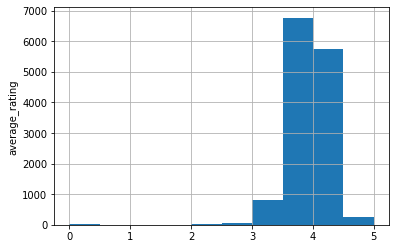

In [15]:
books['average_rating'].hist()
plt.ylabel('average_rating')
plt.show()



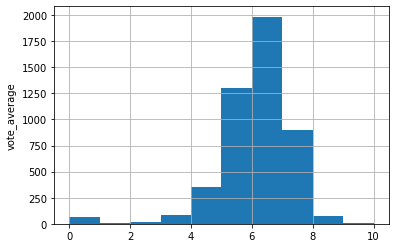

In [16]:
movies['vote_average'].hist()
plt.ylabel('vote_average')
plt.show()

## Basic Visualizations 

### What authors have published the most books?

In [17]:
most_published_authors = books['authors'].value_counts()[:10]
mostcounts = most_published_authors.reset_index()
mostcounts


,index,authors
0,Agatha Christie,69
1,Stephen King,66
2,Orson Scott Card,48
3,Rumiko Takahashi,46
4,P.G. Wodehouse,42
5,Terry Brooks,40
6,Piers Anthony,34
7,Margaret Weis-Tracy Hickman,33
8,Dan Simmons,32
9,Gabriel García Márquez,31


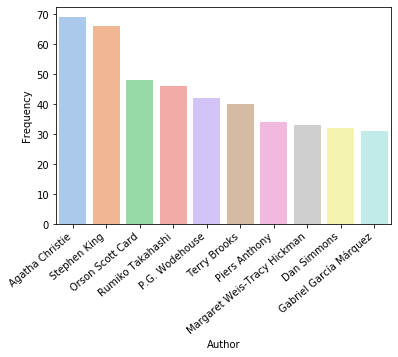

In [18]:
authorplot = sns.barplot(x = 'index',y='authors', data=mostcounts, palette="pastel")
authorplot.set_xticklabels(authorplot.get_xticklabels(), rotation=40, ha="right")
authorplot.set(xlabel='Author', ylabel='Frequency')
plt.show()

### What are the 25 highest rated books?

In [19]:
# Do with groupby?

highest_rated_all = books.sort_values('average_rating', ascending=False)[:100]
highest_rated_books = highest_rated_all[['title', 'authors', 'average_rating', 'ratings_count', 'text_reviews_count']]
highest_rated_books


,title,authors,average_rating,ratings_count,text_reviews_count
6077,The Complete Theory Fun Factory: Music Theory Puzzles and Games for the Early Grades,Ian Martin-Katie Elliott,5.00,1,0
4939,Zone of the Enders: The 2nd Runner Official Strategy Guide,Tim Bogenn,5.00,2,0
963,Literature Circle Guide: Bridge to Terabithia: Everything You Need For Successful Literature Circles That Get Kids Thinking Talking Writing—and Loving Literature,Tara MacCarthy,5.00,4,1
7506,The New Big Book of America,Todd Davis-Marc Frey,5.00,2,1
11067,Bubbles in the Middle (The Powerpuff Girls Plus You Club #16),Aaron Rosenberg-Christopher Cook,5.00,5,0
...,...,...,...,...,...
13708,The Sandman: King of Dreams,Alisa Kwitney-Neil Gaiman,4.62,12775,34
11218,Organizational Architecture: Designs for Changing Organizations,David A. Nadler-Robert B. Shaw-Marc S. Gerstein,4.62,2,0
10721,The Feynman Lectures on Physics Vol 2,Richard P. Feynman-Robert B. Leighton-Matthew L. Sands,4.61,17,2
7555,Nausicaä de la vallée du vent tome 5,Hayao Miyazaki,4.61,55,3


### The above cell showed an important detail, that not all entries have the same amount of reviews

### Let's see what the highest rated books with at least 100 reviews are

In [20]:
highest_with_hundred = highest_rated_all[highest_rated_all['ratings_count'] >= 100][:10]
highest_with_hundred = highest_with_hundred[['title', 'authors', 'average_rating', 'ratings_count']]

fave_cols = highest_with_hundred[['title', 'average_rating']]

highest_with_hundred

,title,authors,average_rating,ratings_count
7922,The Complete Calvin and Hobbes,Bill Watterson,4.82,31249
5,Harry Potter Boxed Set Books 1-5 (Harry Potter #1-5),J.K. Rowling-Mary GrandPré,4.78,38872
8400,It's A Magical World,Bill Watterson,4.76,138
7924,It's a Magical World (Calvin and Hobbes #11),Bill Watterson,4.76,23336
7925,The Indispensable Calvin and Hobbes,Bill Watterson,4.74,15641
7,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,27410
2182,Early Color,Saul Leiter-Martin Harrison,4.73,114
7926,Homicidal Psycho Jungle Cat (Calvin and Hobbes #9),Bill Watterson,4.72,14952
7930,Calvin and Hobbes: Sunday Pages 1985-1995: An Exhibition Catalogue,Bill Watterson,4.71,3537
12976,The Price of the Ticket: Collected Nonfiction 1948-1985,James Baldwin,4.70,396


### The world really likes Calvin and Hobbes

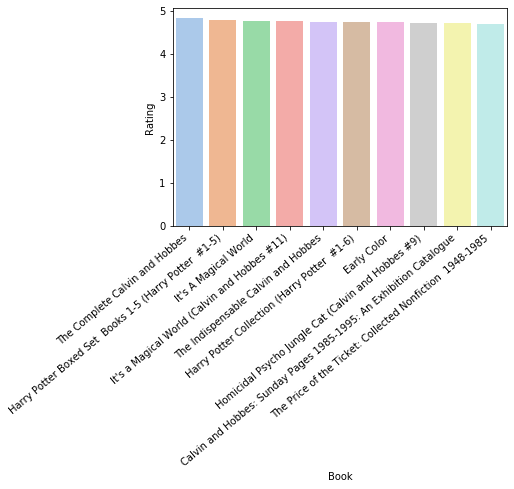

In [21]:
favebookplot = sns.barplot(x = 'title',y='average_rating', data=fave_cols, palette="pastel")
favebookplot.set_xticklabels(favebookplot.get_xticklabels(), rotation=40, ha="right")
favebookplot.set(xlabel='Book', ylabel='Rating')
plt.show()

In [22]:
books.corr()['average_rating']

bookID               -0.04
average_rating        1.00
isbn13                0.00
# num_pages           0.17
ratings_count         0.04
text_reviews_count    0.04
Name: average_rating, dtype: float64

In [23]:
books.corr()['# num_pages'].abs().sort_values(ascending=False)

# num_pages          1.00
average_rating       0.17
text_reviews_count   0.03
ratings_count        0.03
bookID               0.01
isbn13               0.01
Name: # num_pages, dtype: float64

In [24]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

### What are the highest budget movies?

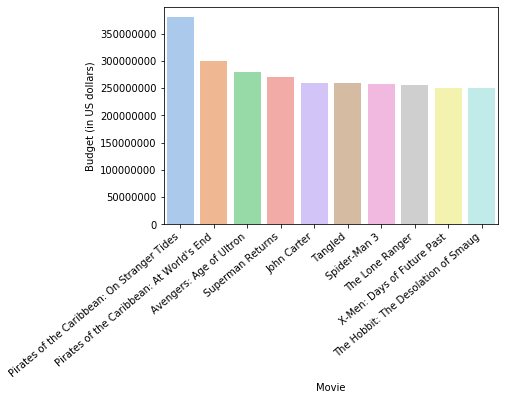

In [25]:
most_expensive_df = movies.sort_values('budget',ascending=False)[:10]

most_expensive = most_expensive_df[['title', 'budget', 'revenue']]

expensiveplot = sns.barplot(x = 'title',y='budget', data=most_expensive, palette="pastel")
expensiveplot.set_xticklabels(expensiveplot.get_xticklabels(), rotation=40, ha="right")
expensiveplot.set(xlabel='Movie', ylabel='Budget (in US dollars)')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [26]:
most_expensive

,title,budget,revenue
17,Pirates of the Caribbean: On Stranger Tides,380000000,1045713802
1,Pirates of the Caribbean: At World's End,300000000,961000000
7,Avengers: Age of Ultron,280000000,1405403694
10,Superman Returns,270000000,391081192
4,John Carter,260000000,284139100
6,Tangled,260000000,591794936
5,Spider-Man 3,258000000,890871626
13,The Lone Ranger,255000000,89289910
46,X-Men: Days of Future Past,250000000,747862775
22,The Hobbit: The Desolation of Smaug,250000000,958400000


### What are the most popular movies?

In [27]:
most_popular_df = movies.sort_values('popularity',ascending=False)[:10]
most_popular = most_popular_df[['title', 'popularity', 'release_date']]
most_popular

,title,popularity,release_date
546,Minions,875.58,2015-06-17
95,Interstellar,724.25,2014-11-05
788,Deadpool,514.57,2016-02-09
94,Guardians of the Galaxy,481.10,2014-07-30
127,Mad Max: Fury Road,434.28,2015-05-13
28,Jurassic World,418.71,2015-06-09
199,Pirates of the Caribbean: The Curse of the Black Pearl,271.97,2003-07-09
82,Dawn of the Planet of the Apes,243.79,2014-06-26
200,The Hunger Games: Mockingjay - Part 1,206.23,2014-11-18
88,Big Hero 6,203.73,2014-10-24


In [28]:
movies.corr()['popularity'].sort_values(ascending=False)

popularity     1.00
vote_count     0.78
revenue        0.64
budget         0.51
vote_average   0.27
runtime        0.23
id             0.03
Name: popularity, dtype: float64

## This section attempts to merge the two datasets


By default, the pandas merge method looks for a shared column in the two datasets. Both books and movies have a 'title' column, so our resulting dataframe should have the amount of entries which have duplicate titles in books and movies

In [29]:
merged = pd.merge(books, movies)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 507
Data columns (total 29 columns):
bookID                  508 non-null int64
title                   508 non-null object
authors                 508 non-null object
average_rating          508 non-null float64
isbn                    508 non-null object
isbn13                  508 non-null int64
language_code           508 non-null object
# num_pages             508 non-null int64
ratings_count           508 non-null int64
text_reviews_count      508 non-null int64
budget                  508 non-null int64
genres                  508 non-null object
homepage                184 non-null object
id                      508 non-null int64
keywords                508 non-null object
original_language       508 non-null object
original_title          508 non-null object
overview                508 non-null object
popularity              508 non-null float64
production_companies    508 non-null object
production_countries

### Everything in this dataframe should be both a book and a movie; does that seem true?

The first entry is Hatchet by Gary Paulsen, the famous survival novel,
but it was merged with what looks like a slasher horror movie.

So this method will combine movie and books of the same title, even if they are different things.

In [78]:
merged.head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,50,Hatchet,Gary Paulsen,3.70,0689840926,9780689840920,eng,208,254827,11346,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 27, ""name"": ""Horror""}]",http://www.hatchetmovie.com/,11908,"[{""id"": 2411, ""name"": ""new orleans""}, {""id"": 3184, ""name"": ""alligator""}, {""id"": 3230, ""name"": ""male friendship""}, {""id"": 3598, ""name"": ""ax""}, {""id"": 4150, ""name"": ""swampf""}, {""id"": 10714, ""name"": ""serial killer""}]",en,Hatchet,"When a group of tourists on a New Orleans haunted swamp tour find themselves stranded in the wilderness, their evening of fun and spooks turns into a horrific nightmare.",12.68,"[{""name"": ""ArieScope Pictures"", ""id"": 3960}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2006-04-27,0,83.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Stay out of the swamp.,5.70,159
1,151,Anna Karenina,Leo Tolstoy-Richard Pevear-Larissa Volokhonsky,4.04,0143035002,9780143035008,eng,838,15747,1795,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""name"": ""Romance""}]",NaN,96724,"[{""id"": 818, ""name"": ""based on novel""}, {""id"": 3563, ""name"": ""st. petersburg russia""}, {""id"": 165282, ""name"": ""high society""}, {""id"": 186004, ""name"": ""imperial russia""}, {""id"": 186009, ""name"": ""tragic death""}, {""id"": 207928, ""name"": ""19th century""}]",en,Anna Karenina,"Trapped in a loveless marriage, aristocrat Anna Karenina enters into a life-changing affair with the affluent Count Vronsky.",26.39,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""name"": ""Focus Features"", ""id"": 10146}, {""name"": ""Working Title Films"", ""id"": 10163}]","[{""iso_3166_1"": ""FR"", ""name"": ""France""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2012-09-06,68929150,130.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""}]",Released,An epic story of love.,6.50,639
2,152,Anna Karenina,Leo Tolstoy-David Magarshack-Priscilla Meyer,4.04,0451528611,9780451528612,eng,960,108970,5694,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""name"": ""Romance""}]",NaN,96724,"[{""id"": 818, ""name"": ""based on novel""}, {""id"": 3563, ""name"": ""st. petersburg russia""}, {""id"": 165282, ""name"": ""high society""}, {""id"": 186004, ""name"": ""imperial russia""}, {""id"": 186009, ""name"": ""tragic death""}, {""id"": 207928, ""name"": ""19th century""}]",en,Anna Karenina,"Trapped in a loveless marriage, aristocrat Anna Karenina enters into a life-changing affair with the affluent Count Vronsky.",26.39,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""name"": ""Focus Features"", ""id"": 10146}, {""name"": ""Working Title Films"", ""id"": 10163}]","[{""iso_3166_1"": ""FR"", ""name"": ""France""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2012-09-06,68929150,130.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""}]",Released,An epic story of love.,6.50,639
3,153,Anna Karenina,Leo Tolstoy-Richard Pevear-Larissa Volokhonsky-John Bayley,4.04,0140449175,9780140449174,eng,837,2835,300,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""name"": ""Romance""}]",NaN,96724,"[{""id"": 818, ""name"": ""based on novel""}, {""id"": 3563, ""name"": ""st. petersburg russia""}, {""id"": 165282, ""name"": ""high society""}, {""id"": 186004, ""name"": ""imperial russia""}, {""id"": 186009, ""name"": ""tragic death""}, {""id"": 207928, ""name"": ""19th century""}]",en,Anna Karenina,"Trapped in a loveless marriage, aristocrat Anna Karenina enters into a life-changing affair with the affluent Count Vronsky.",26.39,"[{""name"": 

### Merge attempt 2
Notice 'keywords' column of Movies seems to have a bit of metadata for SOME movies based on a novel.
If we look for any occurence of the word 'novel' in the 'keywords' section of each movie, we get 241 results.

### Working algorithm for merging on books/movies
1.   Look for movies which explicitly say based on novel
2.   Look for matching titles

      a. Titles must have at least x words or characters in common to be considered, i.e. rule out 'Hatchet' case

      b. Use fuzzy wuzzy for partial string matching
3. (Optional)    Look for reference to book author or characters in movie credits

      a. Credits 'cast' field has character names, look for top 3 character neames in title of book
4.   Merge step 1-3 results
5.   Check for duplicated
6.   Verify somehow


Look for 3rd party dataset: wikipedia?

#### 1.
Grab the movie entries who explicitly have the word 'novel' in their keywords. This is vague enough to lead to errors, but shows good results for this dataset. There are 241 entries. 

In [0]:
select_novel_from_movies = movies[movies['keywords'].str.contains('novel')]

#select_novel_from_movies.head(10)

We saw the MOVIES that say they are based on a novel, merge2 combines that with books to see those that are actually in the books dataset.

In [32]:
merge2 = pd.merge(books, select_novel_from_movies)
merge2.info()
# 119 entries




<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 29 columns):
bookID                  119 non-null int64
title                   119 non-null object
authors                 119 non-null object
average_rating          119 non-null float64
isbn                    119 non-null object
isbn13                  119 non-null int64
language_code           119 non-null object
# num_pages             119 non-null int64
ratings_count           119 non-null int64
text_reviews_count      119 non-null int64
budget                  119 non-null int64
genres                  119 non-null object
homepage                51 non-null object
id                      119 non-null int64
keywords                119 non-null object
original_language       119 non-null object
original_title          119 non-null object
overview                119 non-null object
popularity              119 non-null float64
production_companies    119 non-null object
production_countries 

In [0]:
books_for_match = books.copy()
movies_for_match = movies.copy()


Now we are looking to do exact title matches.

Thinking back to the 'Hatchet' example, we can prune some values.
Can drop titles with only one word, since it is highly likely single word titles have been used repeatedly.

The below code drops 800 book rows, 1000 movie rows

I made copies of the dataset here rather than modifying the original.

In [0]:
books_for_match['wordcount'] = books_for_match['title'].str.split().str.len()
books_for_match = books_for_match[books_for_match['wordcount'] > 1]
movies_for_match['wordcount'] = movies_for_match['title'].str.split().str.len()
movies_for_match = movies_for_match[movies_for_match['wordcount'] > 1]


In [0]:
# try merging these two
merge3 = pd.merge(books_for_match, movies_for_match)

#merge3.info()
merge3.head(10);

In merged2 we combined: books and movies explicitly marked as being based on a book.
In merged3 we combined: all books and movies with titles greater than 1 word

We want to combine these without the duplicates, try pandas method 'concat'

In [36]:
merge4 = pd.concat([merge2,merge3],sort=True).drop_duplicates().reset_index(drop=True)

merge4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 30 columns):
# num_pages             520 non-null int64
authors                 520 non-null object
average_rating          520 non-null float64
bookID                  520 non-null int64
budget                  520 non-null int64
genres                  520 non-null object
homepage                204 non-null object
id                      520 non-null int64
isbn                    520 non-null object
isbn13                  520 non-null int64
keywords                520 non-null object
language_code           520 non-null object
original_language       520 non-null object
original_title          520 non-null object
overview                520 non-null object
popularity              520 non-null float64
production_companies    520 non-null object
production_countries    520 non-null object
ratings_count           520 non-null int64
release_date            520 non-null object
revenue            

#### The above dataframe merge4, is our most accurate and complete thus far. It has 520 entries, but with notable absences like the Harry Potter series. The reason for this is that the book entries have more complex titles. See below.

In [37]:
books[books['title'].str.contains('Har')]['title'][:5], ' ', movies[movies['title'].str.contains('Har')]['title'][:5]

(0       Harry Potter and the Half-Blood Prince (Harry Potter  #6)
 1    Harry Potter and the Order of the Phoenix (Harry Potter  #5)
 2        Harry Potter and the Sorcerer's Stone (Harry Potter  #1)
 3      Harry Potter and the Chamber of Secrets (Harry Potter  #2)
 4     Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
 Name: title, dtype: object,
 ' ',
 8         Harry Potter and the Half-Blood Prince
 110                                 Pearl Harbor
 113    Harry Potter and the Order of the Phoenix
 114          Harry Potter and the Goblet of Fire
 191     Harry Potter and the Prisoner of Azkaban
 Name: title, dtype: object)

#### One potential solution would be to manually remove differences like the trailing (Harry Potter '#') book entries, but it would be difficult to identify those in a general case. 

A better solution is to use partial string matching, to say that if two strings are at least xx% the same, we will consider them a match. The fuzzywuzzy library for Python implements partial string matching using the Levenshtein Distance.

#### 2. 

Compare titles 1: O(n^2) over ~15,000 elements

    for the title of each book entry:  
     compare to the title of each movie entry:
        if titles are within acceptabe range of same:
          found match!


Look for pandas vectorized operations to do above:



In [0]:
def find_matches(df, column, string_to_match, min_ratio):
    # get a list of unique strings
    #print('string_to_match',string_to_match)
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    #print('matches', matches)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    #print('close_matches',close_matches)
    return close_matches





In [85]:
matches_dict = {}
# smaller_book_section works
for i in books['title']:
  tmp = find_matches(movies, column='title', string_to_match=str(i),min_ratio=85)
  if tmp != []:
    matches_dict[i] = tmp

# takes ~11 minutes

same_names = pd.DataFrame.from_dict(matches_dict, orient='index')
same_names = same_names.reset_index()
same_names = same_names[['index',0]]
same_names.columns = ['Book', 'Movie']

# Same names shows all of the book/movie title matches at an 80% threshold
same_names

,Book,Movie
0,Harry Potter and the Order of the Phoenix (Harry Potter #5),Harry Potter and the Order of the Phoenix
1,The Ultimate Hitchhiker's Guide to the Galaxy,The Hitchhiker's Guide to the Galaxy
2,The Fellowship of the Ring (The Lord of the Rings #1),The Lord of the Rings: The Fellowship of the Ring
3,Hatchet,Hatchet
4,The Known World,The New World
...,...,...
497,The Book of Joe,The Book of Eli
498,Alexander and the Terrible Horrible No Good Very Bad Day,"Alexander and the Terrible, Horrible, No Good, Very Bad Day"
499,Requiem for a Dream,Requiem for a Dream
500,Chocolat,Chocolat


In [86]:
same_names[same_names['Book'].str.contains('Potter')]

,Book,Movie
0,Harry Potter and the Order of the Phoenix (Harry Potter #5),Harry Potter and the Order of the Phoenix


In [0]:
one_word_titles = same_names[same_names['Book'].str.split().str.len() == 1]
one_word_dict = {}
for i in one_word_titles['Book']:
  tmp = find_matches(one_word_titles, column='Movie', string_to_match=str(i),min_ratio=95)
  if tmp != []:
    one_word_dict[i] = tmp

# one_word_dict shows all one word title book/movie matches at a 90% threshold
one_word_dict
one_word_df = pd.DataFrame.from_dict(one_word_dict, orient='index')
one_word_df = one_word_df.reset_index()
one_word_df

#one_word_df = one_word_df[['index',0]]
one_word_df.columns = ['Book', 'Movie']
#one_word_df


In [41]:
same_names_no_ones = same_names[same_names['Book'].str.split().str.len() > 1]

# can later choose to drop one word titles completely
same_names_final = pd.concat([same_names_no_ones, one_word_df],sort=True).drop_duplicates().reset_index(drop=True)


# *********
# Final title matched dataframe
same_names_final



,Book,Movie
0,Harry Potter and the Order of the Phoenix (Harry Potter #5),Harry Potter and the Order of the Phoenix
1,The Ultimate Hitchhiker's Guide to the Galaxy,The Hitchhiker's Guide to the Galaxy
2,The Fellowship of the Ring (The Lord of the Rings #1),The Lord of the Rings: The Fellowship of the Ring
3,The Known World,The New World
4,Anna Karenina,Anna Karenina
...,...,...
475,Holes,Holes
476,After,After
477,Thirteen,Thirteen
478,Monster,Monster


In [0]:
get_data_from_names = []
for i in same_names_final['Book']:
  get = books[books['title'] == i]
  get_data_from_names.append(get.sort_values(by='ratings_count',ascending=False)[:1])

book_to_list = same_names_final['Book'].tolist()
movie_to_list = same_names_final['Movie'].tolist()

get_matched_books = books[books['title'].isin(book_to_list)]
get_matched_movies = movies[movies['title'].isin(movie_to_list)]

#get_matched_books['title'].value_counts()
#get_matched_movies

### Merge String-matched Titles

In [60]:
df = pd.merge(get_matched_books,get_matched_movies)
df.head(10)


,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,50,Hatchet,Gary Paulsen,3.70,0689840926,9780689840920,eng,208,254827,11346,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 27, ""name"": ""Horror""}]",http://www.hatchetmovie.com/,11908,"[{""id"": 2411, ""name"": ""new orleans""}, {""id"": 3184, ""name"": ""alligator""}, {""id"": 3230, ""name"": ""male friendship""}, {""id"": 3598, ""name"": ""ax""}, {""id"": 4150, ""name"": ""swampf""}, {""id"": 10714, ""name"": ""serial killer""}]",en,Hatchet,"When a group of tourists on a New Orleans haunted swamp tour find themselves stranded in the wilderness, their evening of fun and spooks turns into a horrific nightmare.",12.68,"[{""name"": ""ArieScope Pictures"", ""id"": 3960}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2006-04-27,0,83.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Stay out of the swamp.,5.70,159
1,151,Anna Karenina,Leo Tolstoy-Richard Pevear-Larissa Volokhonsky,4.04,0143035002,9780143035008,eng,838,15747,1795,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""name"": ""Romance""}]",NaN,96724,"[{""id"": 818, ""name"": ""based on novel""}, {""id"": 3563, ""name"": ""st. petersburg russia""}, {""id"": 165282, ""name"": ""high society""}, {""id"": 186004, ""name"": ""imperial russia""}, {""id"": 186009, ""name"": ""tragic death""}, {""id"": 207928, ""name"": ""19th century""}]",en,Anna Karenina,"Trapped in a loveless marriage, aristocrat Anna Karenina enters into a life-changing affair with the affluent Count Vronsky.",26.39,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""name"": ""Focus Features"", ""id"": 10146}, {""name"": ""Working Title Films"", ""id"": 10163}]","[{""iso_3166_1"": ""FR"", ""name"": ""France""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2012-09-06,68929150,130.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""}]",Released,An epic story of love.,6.50,639
2,152,Anna Karenina,Leo Tolstoy-David Magarshack-Priscilla Meyer,4.04,0451528611,9780451528612,eng,960,108970,5694,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""name"": ""Romance""}]",NaN,96724,"[{""id"": 818, ""name"": ""based on novel""}, {""id"": 3563, ""name"": ""st. petersburg russia""}, {""id"": 165282, ""name"": ""high society""}, {""id"": 186004, ""name"": ""imperial russia""}, {""id"": 186009, ""name"": ""tragic death""}, {""id"": 207928, ""name"": ""19th century""}]",en,Anna Karenina,"Trapped in a loveless marriage, aristocrat Anna Karenina enters into a life-changing affair with the affluent Count Vronsky.",26.39,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""name"": ""Focus Features"", ""id"": 10146}, {""name"": ""Working Title Films"", ""id"": 10163}]","[{""iso_3166_1"": ""FR"", ""name"": ""France""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2012-09-06,68929150,130.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""}]",Released,An epic story of love.,6.50,639
3,153,Anna Karenina,Leo Tolstoy-Richard Pevear-Larissa Volokhonsky-John Bayley,4.04,0140449175,9780140449174,eng,837,2835,300,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""name"": ""Romance""}]",NaN,96724,"[{""id"": 818, ""name"": ""based on novel""}, {""id"": 3563, ""name"": ""st. petersburg russia""}, {""id"": 165282, ""name"": ""high society""}, {""id"": 186004, ""name"": ""imperial russia""}, {""id"": 186009, ""name"": ""tragic death""}, {""id"": 207928, ""name"": ""19th century""}]",en,Anna Karenina,"Trapped in a loveless marriage, aristocrat Anna Karenina enters into a life-changing affair with the affluent Count Vronsky.",26.39,"[{""name"": 

Now we have the title matches.

Combine with entries based on a novel.

Check for duplicates and remove.



### Verify


Steps:
*   Can see if languages are the same
*   Look for 'based on novel' type phrase in movie: keywords, genre, credits
*   Look for reference to book author in movie credits or production company
*   Variation in title?



For title in merged set:

  grab first author from each row
  
    look for author in crew of credits for that title



'authors' column includes foreward writers, translators etc. The first entry is always the actual author, so grab that and make an 'author' column.

In [0]:
grab = df['authors'].str.split('-')
grab = grab.apply(lambda x: x[0])
df['author'] = grab


In [62]:
df = pd.merge(df, credits)
df

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,author,movie_id,cast,crew
0,50,Hatchet,Gary Paulsen,3.70,0689840926,9780689840920,eng,208,254827,11346,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 27, ""name"": ""Horror""}]",http://www.hatchetmovie.com/,11908,"[{""id"": 2411, ""name"": ""new orleans""}, {""id"": 3184, ""name"": ""alligator""}, {""id"": 3230, ""name"": ""male friendship""}, {""id"": 3598, ""name"": ""ax""}, {""id"": 4150, ""name"": ""swampf""}, {""id"": 10714, ""name"": ""serial killer""}]",en,Hatchet,"When a group of tourists on a New Orleans haunted swamp tour find themselves stranded in the wilderness, their evening of fun and spooks turns into a horrific nightmare.",12.68,"[{""name"": ""ArieScope Pictures"", ""id"": 3960}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2006-04-27,0,83.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Stay out of the swamp.,5.70,159,Gary Paulsen,11908,"[{""cast_id"": 11, ""character"": ""Ben"", ""credit_id"": ""52fe449f9251416c7503b403"", ""gender"": 2, ""id"": 59231, ""name"": ""Joel David Moore"", ""order"": 0}, {""cast_id"": 12, ""character"": ""Marybeth"", ""credit_id"": ""52fe449f9251416c7503b407"", ""gender"": 1, ""id"": 70899, ""name"": ""Tamara Feldman"", ""order"": 1}, {""cast_id"": 13, ""character"": ""Marcus"", ""credit_id"": ""52fe449f9251416c7503b40b"", ""gender"": 2, ""id"": 35596, ""name"": ""Deon Richmond"", ""order"": 2}, {""cast_id"": 14, ""character"": ""Victor Crowley"", ""credit_id"": ""52fe449f9251416c7503b40f"", ""gender"": 2, ""id"": 62596, ""name"": ""Kane Hodder"", ""order"": 3}, {""cast_id"": 16, ""character"": ""Misty"", ""credit_id"": ""52fe449f9251416c7503b419"", ""gender"": 1, ""id"": 123149, ""name"": ""Mercedes McNab"", ""order"": 4}, {""cast_id"": 17, ""character"": ""Shawn"", ""credit_id"": ""52fe449f9251416c7503b41d"", ""gender"": 2, ""id"": 77993, ""name"": ""Parry Shen"", ""order"": 5}, {""cast_id"": 18, ""character"": ""Doug Shapiro"", ""credit_id"": ""52fe449f9251416c7503b421"", ""gender"": 2, ""id"": 155649, ""name"": ""Joe...","[{""credit_id"": ""52fe449f9251416c7503b3ff"", ""department"": ""Editing"", ""gender"": 2, ""id"": 56989, ""job"": ""Editor"", ""name"": ""Christopher Roth""}, {""credit_id"": ""52fe449f9251416c7503b3cf"", ""department"": ""Directing"", ""gender"": 2, ""id"": 70890, ""job"": ""Director"", ""name"": ""Adam Green""}, {""credit_id"": ""52fe449f9251416c7503b415"", ""department"": ""Writing"", ""gender"": 2, ""id"": 70890, ""job"": ""Screenplay"", ""name"": ""Adam Green""}, {""credit_id"": ""52fe449f9251416c7503b3d5"", ""department"": ""Production"", ""gender"": 2, ""id"": 70892, ""job"": ""Producer"", ""name"": ""Scott Altomare""}, {""credit_id"": ""52fe449f9251416c7503b3db"", ""department"": ""Production"", ""gender"": 1, ""id"": 70893, ""job"": ""Producer"", ""name"": ""Sarah Elbert""}, {""credit_id"": ""52fe449f9251416c7503b3e1"", ""department"": ""Production"", ""gender"": 0, ""id"": 70894, ""job"": ""Executive Producer"", ""name"": ""Roman Kindrachuk""}, {""credit_id"": ""52fe449f9251416c7503b3e7"", ""department"": ""Production"", ""gender"": 2, ""id"": 70895, ""job"": ""Executive Producer"", ""name"": ""Andrew Mysko..."
1,151,Anna Karenina,Leo Tolstoy-Richard Pevear-Larissa Volokhonsky,4.04,0143035002,9780143035008,eng,838,15747,1795,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""name"": ""Romance""}]",NaN,96724,"[{""id"": 818, ""name"": ""based on novel""}, {""id"": 3563, ""name"": ""st. petersburg russia""}, {""id"": 165282, ""name"": ""high society""}, {""id"": 186004, ""name"": ""imperial russia""}, {""id"": 186009, ""name"": ""tragic death""}, {""id"": 207928, ""name"": ""19th century"

In [89]:
# Incomplete Verification Function

a = df[df['crew'].str.contains('Novel')]
a = a['crew']
a

2      [{"credit_id": "52fe49bf9251416c750d218b", "department": "Writing", "gender": 2, "id": 372, "job": "Screenplay", "name": "Tom Stoppard"}, {"credit_id": "55530a6cc3a3686341001117", "department": "Production", "gender": 1, "id": 474, "job": "Casting", "name": "Jina Jay"}, {"credit_id": "555309b6c3a3686349000f75", "department": "Production", "gender": 2, "id": 2236, "job": "Producer", "name": "Tim Bevan"}, {"credit_id": "555309d99251414994000e9f", "department": "Production", "gender": 2, "id": 2238, "job": "Producer", "name": "Eric Fellner"}, {"credit_id": "55530a35925141499e000fef", "department": "Camera", "gender": 0, "id": 3285, "job": "Director of Photography", "name": "Seamus McGarvey"}, {"credit_id": "599b0ea6c3a3681df60009df", "department": "Sound", "gender": 0, "id": 9651, "job": "Sound Designer", "name": "Craig Berkey"}, {"credit_id": "55530a229251414992000eae", "department": "Sound", "gender": 0, "id": 11269, "job": "Music", "name": "Dario Marianelli"}, {"credit_id": "52f

## Merged Set Descriptives
Using merge4, acknowledging that it is currently incomplete

In [93]:
grab_duplicates = df.sort_values('ratings_count', ascending=False).duplicated(['title'], keep = 'first')
grab_duplicates

99     False
366    False
48     False
27     False
262    False
       ...  
376    False
386    False
364    False
292    False
400    False
Length: 300, dtype: bool

In [94]:
df = df.drop(df[test].index)
df.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,author,movie_id,cast,crew,Combined Rating
0,50,Hatchet,Gary Paulsen,3.70,0689840926,9780689840920,eng,208,254827,11346,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 27, ""name"": ""Horror""}]",http://www.hatchetmovie.com/,11908,"[{""id"": 2411, ""name"": ""new orleans""}, {""id"": 3184, ""name"": ""alligator""}, {""id"": 3230, ""name"": ""male friendship""}, {""id"": 3598, ""name"": ""ax""}, {""id"": 4150, ""name"": ""swampf""}, {""id"": 10714, ""name"": ""serial killer""}]",en,Hatchet,"When a group of tourists on a New Orleans haunted swamp tour find themselves stranded in the wilderness, their evening of fun and spooks turns into a horrific nightmare.",12.68,"[{""name"": ""ArieScope Pictures"", ""id"": 3960}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2006-04-27,0,83.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Stay out of the swamp.,5.70,159,Gary Paulsen,11908,"[{""cast_id"": 11, ""character"": ""Ben"", ""credit_id"": ""52fe449f9251416c7503b403"", ""gender"": 2, ""id"": 59231, ""name"": ""Joel David Moore"", ""order"": 0}, {""cast_id"": 12, ""character"": ""Marybeth"", ""credit_id"": ""52fe449f9251416c7503b407"", ""gender"": 1, ""id"": 70899, ""name"": ""Tamara Feldman"", ""order"": 1}, {""cast_id"": 13, ""character"": ""Marcus"", ""credit_id"": ""52fe449f9251416c7503b40b"", ""gender"": 2, ""id"": 35596, ""name"": ""Deon Richmond"", ""order"": 2}, {""cast_id"": 14, ""character"": ""Victor Crowley"", ""credit_id"": ""52fe449f9251416c7503b40f"", ""gender"": 2, ""id"": 62596, ""name"": ""Kane Hodder"", ""order"": 3}, {""cast_id"": 16, ""character"": ""Misty"", ""credit_id"": ""52fe449f9251416c7503b419"", ""gender"": 1, ""id"": 123149, ""name"": ""Mercedes McNab"", ""order"": 4}, {""cast_id"": 17, ""character"": ""Shawn"", ""credit_id"": ""52fe449f9251416c7503b41d"", ""gender"": 2, ""id"": 77993, ""name"": ""Parry Shen"", ""order"": 5}, {""cast_id"": 18, ""character"": ""Doug Shapiro"", ""credit_id"": ""52fe449f9251416c7503b421"", ""gender"": 2, ""id"": 155649, ""name"": ""Joe...","[{""credit_id"": ""52fe449f9251416c7503b3ff"", ""department"": ""Editing"", ""gender"": 2, ""id"": 56989, ""job"": ""Editor"", ""name"": ""Christopher Roth""}, {""credit_id"": ""52fe449f9251416c7503b3cf"", ""department"": ""Directing"", ""gender"": 2, ""id"": 70890, ""job"": ""Director"", ""name"": ""Adam Green""}, {""credit_id"": ""52fe449f9251416c7503b415"", ""department"": ""Writing"", ""gender"": 2, ""id"": 70890, ""job"": ""Screenplay"", ""name"": ""Adam Green""}, {""credit_id"": ""52fe449f9251416c7503b3d5"", ""department"": ""Production"", ""gender"": 2, ""id"": 70892, ""job"": ""Producer"", ""name"": ""Scott Altomare""}, {""credit_id"": ""52fe449f9251416c7503b3db"", ""department"": ""Production"", ""gender"": 1, ""id"": 70893, ""job"": ""Producer"", ""name"": ""Sarah Elbert""}, {""credit_id"": ""52fe449f9251416c7503b3e1"", ""department"": ""Production"", ""gender"": 0, ""id"": 70894, ""job"": ""Executive Producer"", ""name"": ""Roman Kindrachuk""}, {""credit_id"": ""52fe449f9251416c7503b3e7"", ""department"": ""Production"", ""gender"": 2, ""id"": 70895, ""job"": ""Executive Producer"", ""name"": ""Andrew Mysko...",6.55
2,152,Anna Karenina,Leo Tolstoy-David Magarshack-Priscilla Meyer,4.04,0451528611,9780451528612,eng,960,108970,5694,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""name"": ""Romance""}]",NaN,96724,"[{""id"": 818, ""name"": ""based on novel""}, {""id"": 3563, ""name"": ""st. petersburg russia""}, {""id"": 165282, ""name"": ""high society""}, {""id"": 186004, ""name"": ""imperial russia""}, {""id"": 186009, ""name"": ""tragic death""}, {""id"": 207928, ""nam

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 506
Data columns (total 34 columns):
bookID                  300 non-null int64
title                   300 non-null object
authors                 300 non-null object
average_rating          300 non-null float64
isbn                    300 non-null object
isbn13                  300 non-null int64
language_code           300 non-null object
# num_pages             300 non-null int64
ratings_count           300 non-null int64
text_reviews_count      300 non-null int64
budget                  300 non-null int64
genres                  300 non-null object
homepage                114 non-null object
id                      300 non-null int64
keywords                300 non-null object
original_language       300 non-null object
original_title          300 non-null object
overview                300 non-null object
popularity              300 non-null float64
production_companies    300 non-null object
production_countries

In [96]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bookID,300.00,17645.15,12660.97,50.00,6848.75,13118.00,28047.75,47423.00
average_rating,300.00,3.91,0.24,2.86,3.79,3.93,4.07,4.44
isbn13,300.00,9780682686157.89,903300545.20,9780006498520.00,9780312335821.00,9780451207681.00,9780748008891.25,9789998691568.00
# num_pages,300.00,328.59,198.43,0.00,214.25,306.50,389.25,1463.00
ratings_count,300.00,124713.79,254266.91,1.00,1205.00,12073.00,129225.75,1464909.00
text_reviews_count,300.00,3397.43,8011.85,0.00,90.25,682.00,3284.75,84237.00
budget,300.00,34078349.31,38056483.89,0.00,5000000.00,22500000.00,50000000.00,200000000.00
id,300.00,31008.54,66113.94,66.00,1860.75,10218.00,21144.25,360339.00
popularity,300.00,27.04,24.77,0.00,10.74,20.28,36.59,146.76
revenue,300.00,95207545.64,147133796.04,0.00,7818621.00,39858866.50,122915909.00,1025491110.00


In [97]:
df['title'].unique()

array(['Hatchet', 'Anna Karenina', 'The Untouchables', 'Love Letters',
       'Perfume: The Story of a Murderer', 'Underworld',
       'The Lovely Bones', 'London', 'Zodiac', 'The Kite Runner',
       'Pompeii', 'Memoirs of a Geisha', 'The Da Vinci Code', '1776',
       'Snow Flower and the Secret Fan', 'Life of Pi', 'Hamlet',
       'Veronika Decides to Die', 'Brokeback Mountain',
       'The Men Who Stare at Goats', 'Into the Wild', 'Pride & Prejudice',
       'Little Women', 'The Hours', 'A Home at the End of the World',
       'In Cold Blood', 'The House of Mirth', 'Moby Dick',
       'The Time Machine', 'Blindness', 'The Cave', 'On the Road',
       'To Kill a Mockingbird', 'Bridge to Terabithia',
       'Girl with a Pearl Earring', 'A Room with a View', 'Howards End',
       'Maurice', 'Runaway Bride', 'Message in a Bottle',
       'A Walk to Remember', 'The Giver', 'The Quiet American',
       'American Psycho', 'From Russia with Love', 'Fever Pitch',
       'High Fidelity', 'Ab

In [98]:
df['authors'].head(10)

0                                                 Gary Paulsen
2                 Leo Tolstoy-David Magarshack-Priscilla Meyer
9                                      Eliot Ness-Oscar Fraley
10            Kahlil Gibran-Suheil Bushrui-Salma H. Al-Kuzbari
11                               Patrick Süskind-John E. Woods
14                                                 Don DeLillo
15                                                Alice Sebold
19    Lonely Planet-Martin  Hughes-Sarah Johnstone-Tom Masters
20                                             Neal Stephenson
23                                             Khaled Hosseini
Name: authors, dtype: object

In [51]:
df[df['title'].str.contains('Har')]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,movie_id,cast,crew
441,29489,Hard Candy,Angela Knight-Sheri Gilmore-Morgan Hawke,4.00,1596321288,9781596321281,eng,350,554,22,950000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 53, ""name"": ""Thriller""}]",http://hardcandymovie.com/,2652,"[{""id"": 236, ""name"": ""suicide""}, {""id"": 570, ""name"": ""rape""}, {""id"": 965, ""name"": ""age difference""}, {""id"": 1003, ""name"": ""photographer""}, {""id"": 1445, ""name"": ""ice""}, {""id"": 1879, ""name"": ""shower""}, {""id"": 2250, ""name"": ""menace""}, {""id"": 2251, ""name"": ""lie""}, {""id"": 2337, ""name"": ""pedophilia""}, {""id"": 2887, ""name"": ""manipulation""}, {""id"": 3303, ""name"": ""bedroom""}, {""id"": 4426, ""name"": ""sadism""}, {""id"": 5157, ""name"": ""electric shock""}, {""id"": 5483, ""name"": ""coffee shop""}, {""id"": 5502, ""name"": ""castration""}, {""id"": 6255, ""name"": ""insanity""}, {""id"": 7002, ""name"": ""vigilante""}, {""id"": 9740, ""name"": ""sociopath""}, {""id"": 9758, ""name"": ""deception""}, {""id"": 10226, ""name"": ""neighbor""}, {""id"": 10809, ""name"": ""teenage girl""}, {""id"": 12544, ""name"": ""crying""}, {""id"": 13006, ""name"": ""torture""}, {""id"": 13125, ""name"": ""sadist""}, {""id"": 14576, ""name"": ""pedophile""}, {""id"": 14624, ""name"": ""cruelty""}, {""id"": 14669, ""name"": ""older man younger woman relationship""}, {""id"": 15068, ""name"": ""one day""}, {""i...",en,Hard Candy,"A mature 14-year old girl meets a charming 32-year old photographer on the Internet. Suspecting that he is a pedophile, she goes to his home in an attempt to expose him.",25.92,"[{""name"": ""Vulcan Productions Inc."", ""id"": 12355}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2005-01-14,7022209,103.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Strangers shouldn't talk to little girls.,6.80,701,2652,"[{""cast_id"": 11, ""character"": ""Jeff Kohlver"", ""credit_id"": ""52fe4363c3a36847f805078d"", ""gender"": 2, ""id"": 17178, ""name"": ""Patrick Wilson"", ""order"": 0}, {""cast_id"": 12, ""character"": ""Hayley Stark"", ""credit_id"": ""52fe4363c3a36847f8050791"", ""gender"": 1, ""id"": 27578, ""name"": ""Ellen Page"", ""order"": 1}, {""cast_id"": 13, ""character"": ""Judy Tokuda"", ""credit_id"": ""52fe4363c3a36847f8050795"", ""gender"": 1, ""id"": 25540, ""name"": ""Sandra Oh"", ""order"": 2}, {""cast_id"": 14, ""character"": ""Janelle Rogers"", ""credit_id"": ""52fe4363c3a36847f8050799"", ""gender"": 1, ""id"": 27579, ""name"": ""Odessa Rae"", ""order"": 3}, {""cast_id"": 15, ""character"": ""Nighthawks Clerk"", ""credit_id"": ""52fe4363c3a36847f805079d"", ""gender"": 0, ""id"": 27580, ""name"": ""G.J. Echternkamp"", ""order"": 4}]","[{""credit_id"": ""52fe4363c3a36847f8050789"", ""department"": ""Production"", ""gender"": 1, ""id"": 859, ""job"": ""Casting"", ""name"": ""Valerie McCaffrey""}, {""credit_id"": ""52fe4363c3a36847f8050777"", ""department"": ""Sound"", ""gender"": 2, ""id"": 20459, ""job"": ""Original Music Composer"", ""name"": ""Harry Escott""}, {""credit_id"": ""52fe4363c3a36847f805077d"", ""department"": ""Sound"", ""gender"": 1, ""id"": 20460, ""job"": ""Original Music Composer"", ""name"": ""Molly Nyman""}, {""credit_id"": ""52fe4363c3a36847f8050759"", ""department"": ""Directing"", ""gender"": 2, ""id"": 27571, ""job"": ""Director"", ""name"": ""David Slade""}, {""credit_id"": ""52fe4363c3a36847f80507a3"", ""department"": ""Writing"", ""gender"": 2, ""id"": 27572, ""job"": ""Writer"", ""name"": ""Brian Nelson""}, {""credit_id"": ""52fe4363c3a36847f805075f"", ""department"": ""Production"", ""gender"": 2, ""id"": 27573, ""job"": ""Producer"", ""na

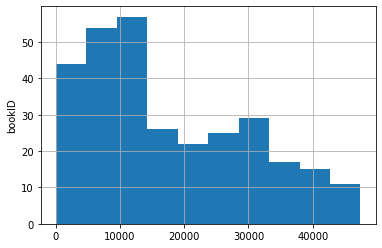

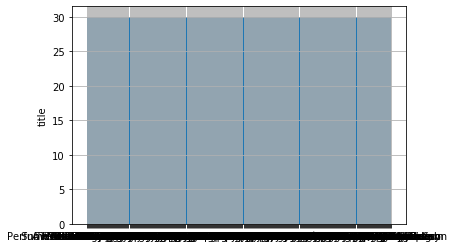

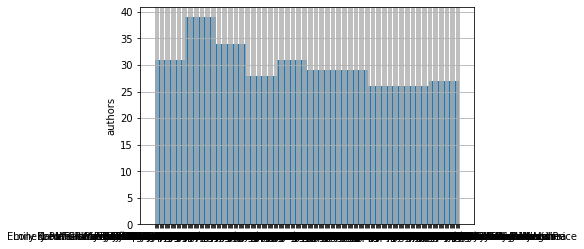

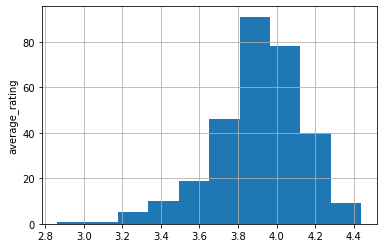

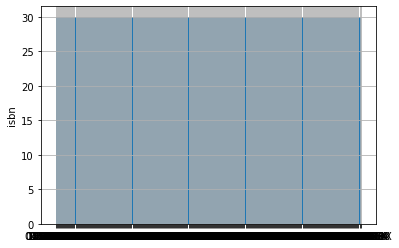

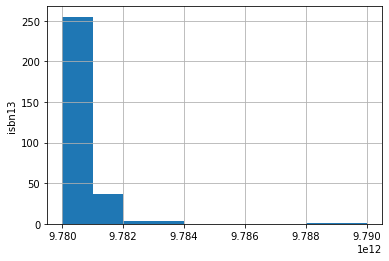

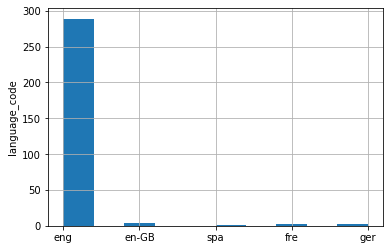

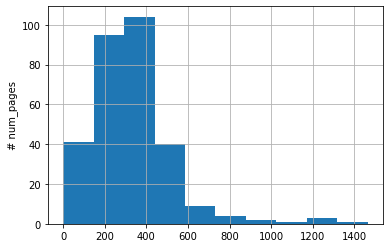

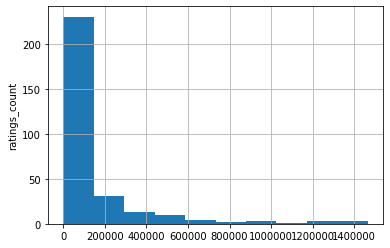

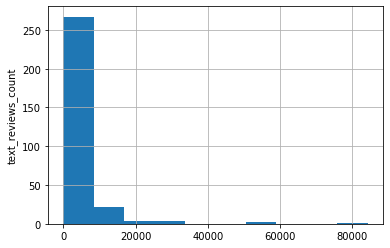

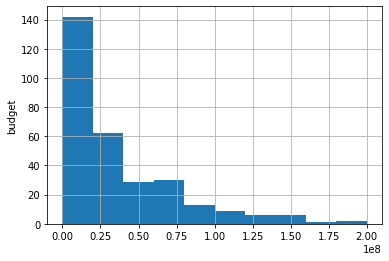

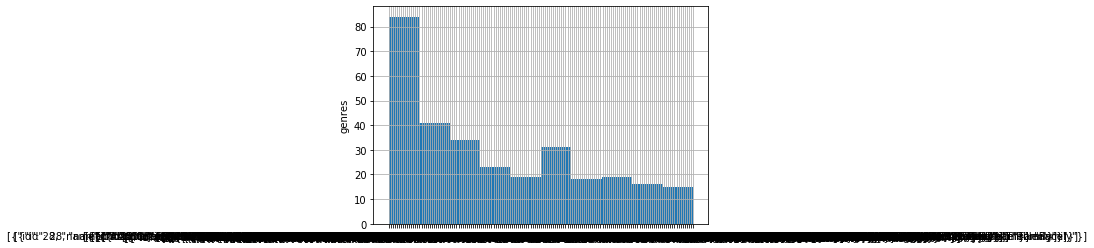

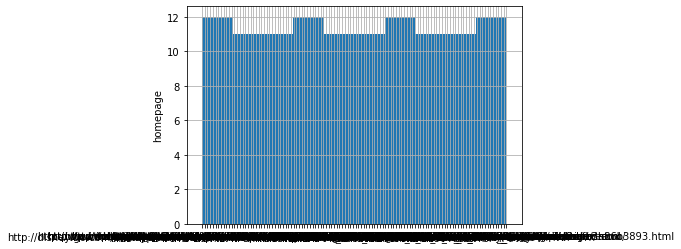

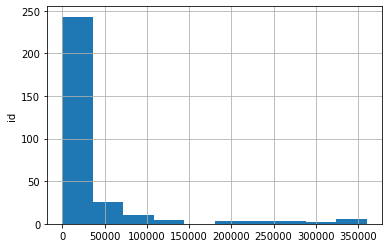

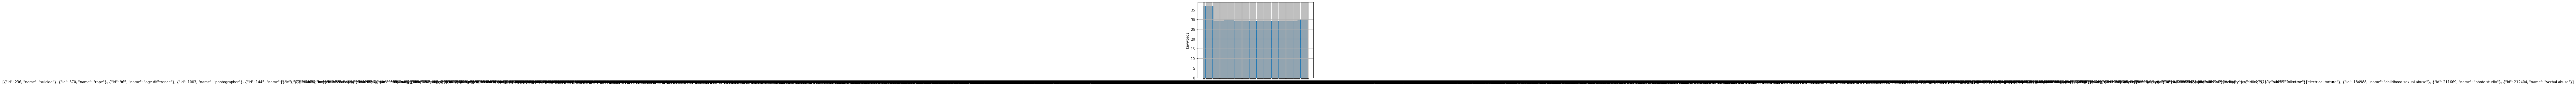

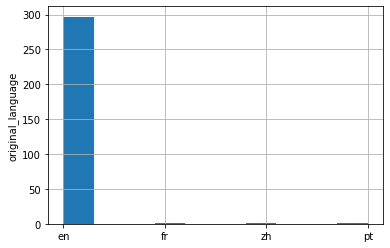

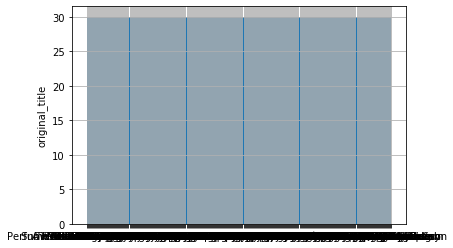

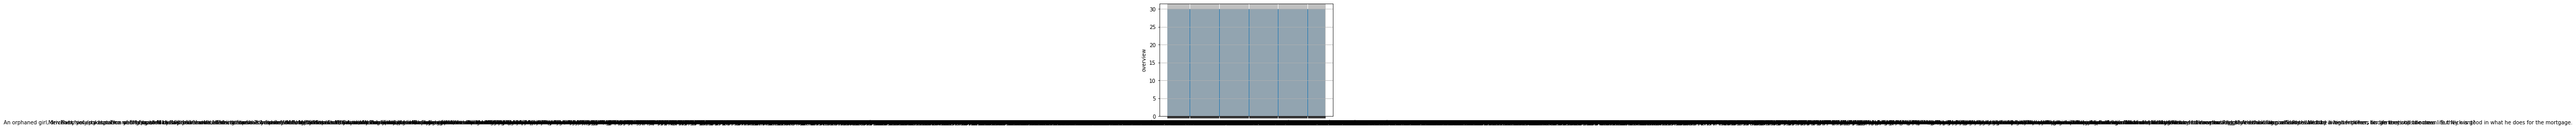

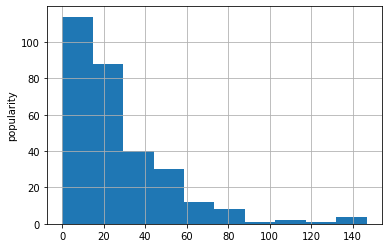

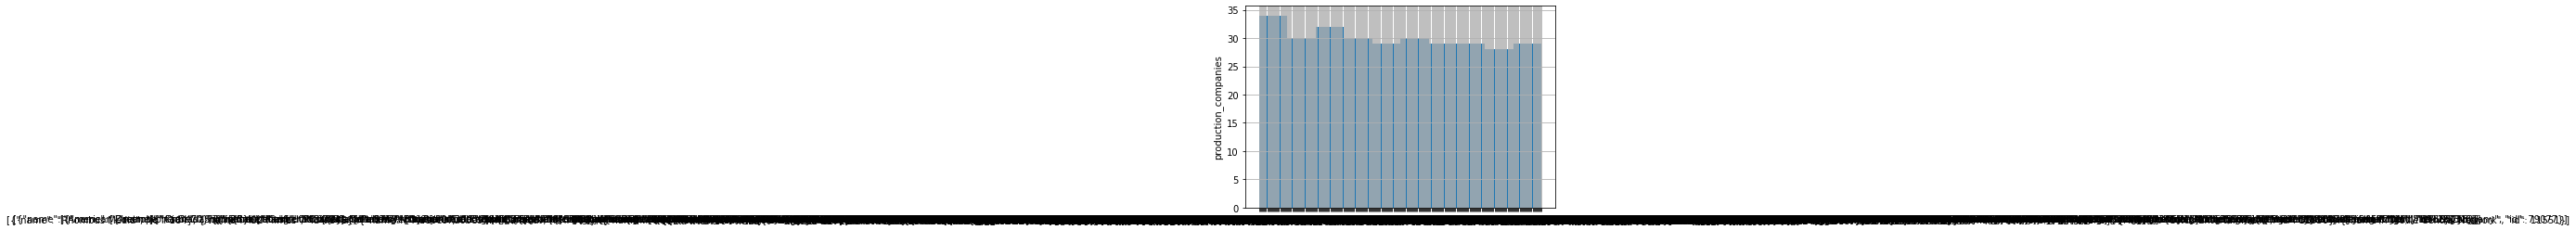

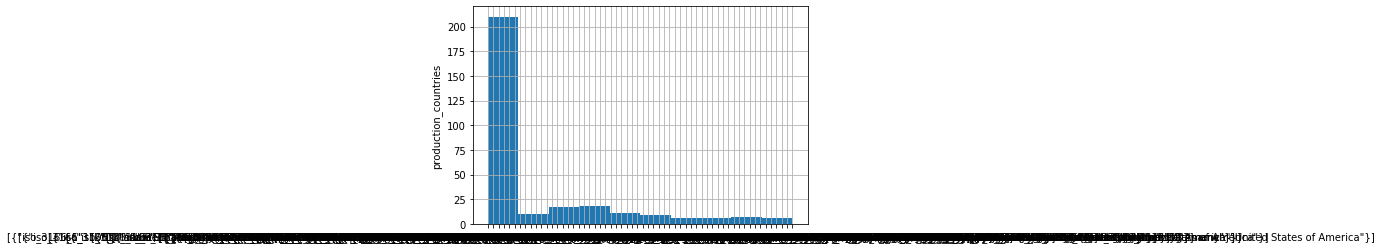

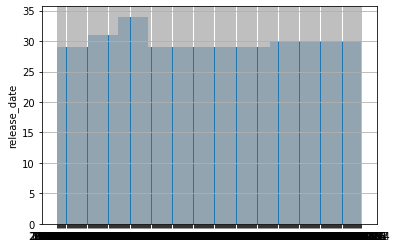

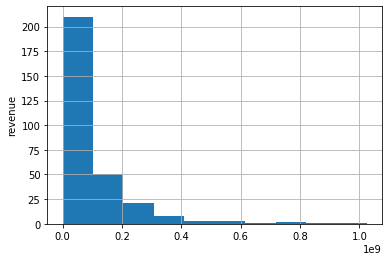

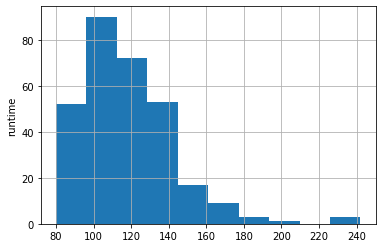

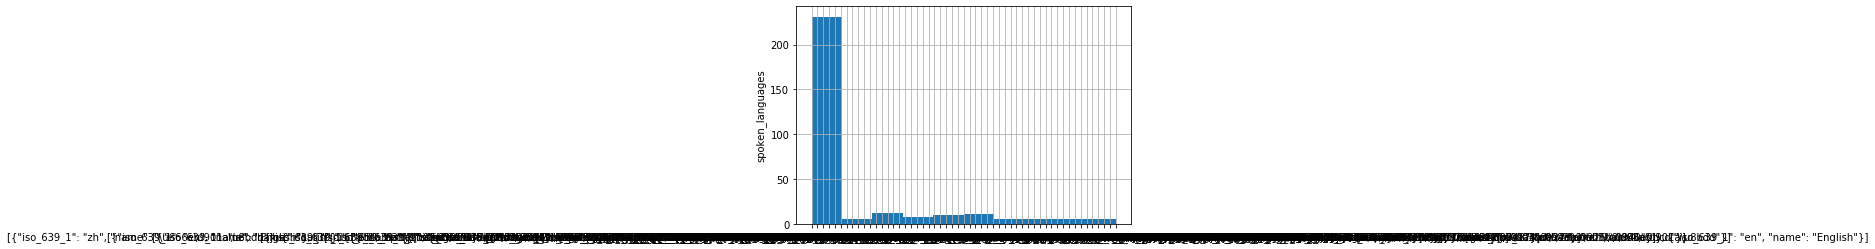

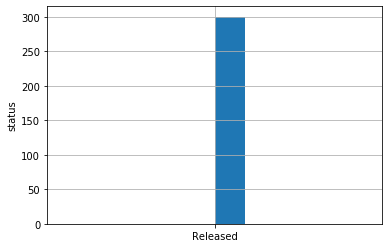

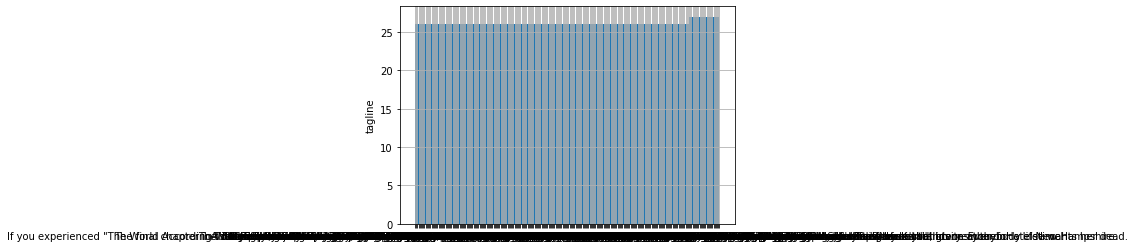

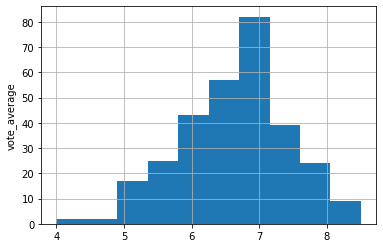

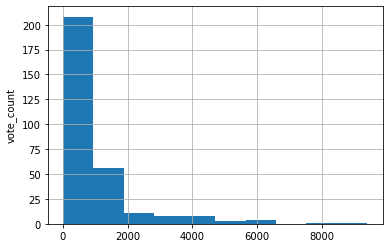

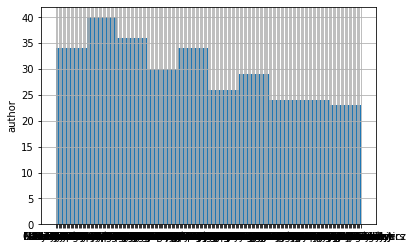

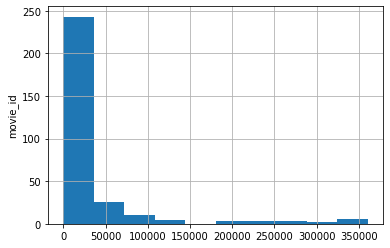

ValueError: ignored

<Figure size 432x288 with 1 Axes>

ValueError: ignored

<Figure size 432x288 with 1 Axes>

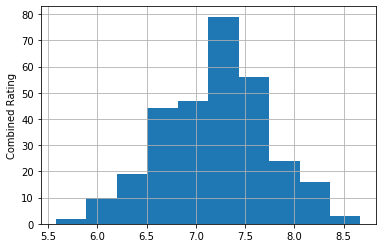

In [76]:
for i in df:
  if df[i].dtype == 'int64' or 'float64':
    df[i].hist()
    plt.ylabel(i)
    plt.show()


### Combined rating
Books on goodreads are rated out out of 5.

Movies are rated out of 10

In comparing a book+movie combination it would make sense to have a total rating that fairly weighs the two scores. For now I am multiplying the book rating by 2, adding it to the movie score, dividing the total by 2.

In [99]:
#col_list = ['average_rating', 'popularity']
df['Combined Rating'] = ((df['average_rating'] * 2)  + df['vote_average']) / 2
print('Highest combined rating')
df.sort_values('Combined Rating', ascending=False)[:10][['title','Combined Rating']]

Highest combined rating


,title,Combined Rating
479,The Shawshank Redemption,8.67
388,The Godfather,8.57
280,The Green Mile,8.54
141,Fight Club,8.35
219,Anne of Green Gables,8.34
401,The Silence of the Lambs,8.32
273,One Flew Over the Cuckoo's Nest,8.29
80,To Kill a Mockingbird,8.27
250,The Shining,8.26
286,Stand by Me,8.23


In [100]:
print('Lowest combined rating')
df.sort_values('Combined Rating', ascending=True)[:10][['title','Combined Rating']]

Lowest combined rating


,title,Combined Rating
238,The Informers,5.58
171,Creature,5.84
10,Love Letters,5.97
365,Brick Lane,6.00
202,Gulliver's Travels,6.01
419,Volcano,6.01
337,Mirror Mirror,6.03
200,Congo,6.08
396,Are We There Yet?,6.10
439,The Prince,6.10


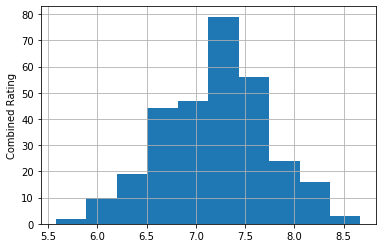

In [101]:
df['Combined Rating'].hist()
plt.ylabel('Combined Rating')
plt.show()

In [73]:
df.corr()['Combined Rating'].abs().sort_values(ascending=False)

Combined Rating      1.00
vote_average         0.92
average_rating       0.74
vote_count           0.46
popularity           0.43
runtime              0.37
ratings_count        0.20
text_reviews_count   0.17
movie_id             0.15
id                   0.15
revenue              0.14
isbn13               0.07
# num_pages          0.06
budget               0.04
bookID               0.01
Name: Combined Rating, dtype: float64

In [104]:
df.corr()['average_rating'].abs().sort_values(ascending=False)

average_rating       1.00
Combined Rating      0.74
vote_average         0.40
vote_count           0.26
ratings_count        0.25
popularity           0.23
text_reviews_count   0.21
runtime              0.21
# num_pages          0.12
revenue              0.09
bookID               0.07
isbn13               0.07
budget               0.04
movie_id             0.00
id                   0.00
Name: average_rating, dtype: float64

In [105]:
df.corr()['vote_average'].abs().sort_values(ascending=False)

vote_average         1.00
Combined Rating      0.92
vote_count           0.46
popularity           0.45
average_rating       0.40
runtime              0.37
movie_id             0.20
id                   0.20
revenue              0.13
ratings_count        0.12
text_reviews_count   0.11
budget               0.08
bookID               0.06
isbn13               0.05
# num_pages          0.01
Name: vote_average, dtype: float64

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
# to predict combined rating
features = df[['vote_average', 'average_rating']]

outcome = df['Combined Rating']

combined_rating_regression = LinearRegression().fit(features, outcome)


In [109]:
print("This model's r-squared is:", combined_rating_regression.score(features,outcome).round(2))

This model's r-squared is: 1.0


In [110]:
# vote_average 7
# average rating 3
print('The predicted combined rating with these ratings is: ', combined_rating_regression.predict([[3.5, 7]]).round(2))

The predicted combined rating with these ratings is:  [8.75]


In [117]:
grab1 = df[df['vote_average'] == 7]

grab1[['average_rating', 'Combined Rating']]

,average_rating,Combined Rating
48,4.06,7.56
54,3.93,7.43
84,3.99,7.49
108,3.94,7.44
124,4.10,7.60
218,3.85,7.35
225,4.16,7.66
272,4.11,7.61
336,3.85,7.35
349,3.83,7.33
